# Разработка алгоритма термодинамических расчетов

Ноутбук для разработки и тестирования алгоритмов расчета термодинамических реакций.

## Цель
Загрузить сырые данные веществ из двух сессий расчетов и проанализировать их для разработки алгоритма.

## 1. Импорт библиотек

In [167]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import sqlite3

# Добавляем корень проекта в путь
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.thermo_agents.search.database_connector import DatabaseConnector
from src.thermo_agents.search.sql_builder import SQLBuilder
from src.thermo_agents.search.compound_searcher import CompoundSearcher

print("✓ Библиотеки импортированы")

✓ Библиотеки импортированы


## 2. Подключение к базе данных

In [168]:
# Путь к базе данных
db_path = project_root / "data" / "thermo_data.db"

if not db_path.exists():
    raise FileNotFoundError(f"База данных не найдена: {db_path}")

# Инициализация компонентов
db_connector = DatabaseConnector(db_path)
sql_builder = SQLBuilder()
searcher = CompoundSearcher(sql_builder, db_connector)

print(f"✓ База данных подключена: {db_path}")
print(f"✓ Размер БД: {db_path.stat().st_size / (1024*1024):.2f} МБ")

✓ База данных подключена: c:\IDE\repository\agents_for_david\data\thermo_data.db
✓ Размер БД: 57.08 МБ


In [169]:
import matplotlib.pyplot as plt

def calculate_cp(record, T):
    """
    Расчёт теплоёмкости Cp(T) по формуле Шомейта.
    
    Cp(T) = f1 + f2*T/1000 + f3*T^(-2)*10^5 + 
            f4*T^2/10^6 + f5*T^(-3)*10^3 + f6*T^3*10^(-9)
    
    Args:
        record: DatabaseRecord с коэффициентами f1-f6
        T: Температура, K
    
    Returns:
        Cp в Дж/(моль·K)
    """
    # DatabaseRecord использует атрибуты, а не словарь
    f1 = record.f1
    f2 = record.f2
    f3 = record.f3
    f4 = record.f4
    f5 = record.f5
    f6 = record.f6
    
    return (
        f1
        + f2 * T / 1000.0
        + f3 * 100_000.0 / (T ** 2)
        + f4 * T**2 / 1_000_000.0
        + f5 * 1_000.0 / (T ** 3)
        + f6 * T**3 * 1e-9
    )


def calculate_H_S(record, reference_record, T, T_ref=298.15, num_points=100):
    """
    Расчёт энтальпии H(T) и энтропии S(T) через численное интегрирование.
    
    Формулы:
    ΔH = ∫(T_ref to T) Cp(T) dT
    H(T) = H₂₉₈ + ΔH
    
    ΔS = ∫(T_ref to T) Cp(T)/T dT
    S(T) = S₂₉₈ + ΔS
    
    Args:
        record: DatabaseRecord с коэффициентами f1-f6 для текущего T-диапазона
        reference_record: DatabaseRecord, содержащая 298.15 K (источник H₂₉₈ и S₂₉₈)
        T: Температура, K
        T_ref: Референсная температура, K (по умолчанию 298.15)
        num_points: Количество точек для численного интегрирования
    
    Returns:
        (H, S) - энтальпия в кДж/моль, энтропия в Дж/(моль·K)
    """
    # DatabaseRecord использует атрибуты, а не словарь
    f1 = record.f1
    f2 = record.f2
    f3 = record.f3
    f4 = record.f4
    f5 = record.f5
    f6 = record.f6
    
    # H298 и S298 берём из референсной записи!
    H298 = reference_record.h298
    S298 = reference_record.s298
    
    # Функция теплоёмкости
    def cp_function(temp):
        return (
            f1
            + f2 * temp / 1000.0
            + f3 * 100_000.0 / (temp ** 2)
            + f4 * temp**2 / 1_000_000.0
            + f5 * 1_000.0 / (temp ** 3)
            + f6 * temp**3 * 1e-9
        )
    
    # Если T равно референсной температуре
    if abs(T - T_ref) < 1e-6:
        return H298, S298
    
    # Численное интегрирование
    temp_points = np.linspace(T_ref, T, num_points)
    cp_values = np.array([cp_function(t) for t in temp_points])
    
    # ΔH = ∫ Cp(T) dT
    delta_H = np.trapz(cp_values, temp_points)
    
    # ΔS = ∫ Cp(T)/T dT
    cp_over_T = cp_values / temp_points
    delta_S = np.trapz(cp_over_T, temp_points)
    
    # Финальные значения
    H = H298 + delta_H / 1000.0  # H298 в кДж/моль, delta_H в Дж/моль
    S = S298 + delta_S
    
    return H, S


print("✓ Функции термодинамических расчетов определены")

✓ Функции термодинамических расчетов определены


In [170]:
# Конфигурация веществ для исследования
# Формат: {formula, name, target_records, phase_transitions, colors}
COMPOUNDS_CONFIG = [
    {
        'formula': 'NH4Cl',
        'name': 'Ammonium chloride',
        'target_records': [
            {'phase': 's', 'tmin': 298.1, 'tmax': 457.9},
            {'phase': 's', 'tmin': 457.9, 'tmax': 800}
        ],
        'phase_transition': {'temp': 793, 'name': 'Плавление'},
        'colors': ['#2E86AB', '#A23B72'],
        'temp_range': (250, 850),
        'key_temps': [298.15, 400, 500, 600, 700, 793]
    },
    {
        'formula': 'CeCl3',
        'name': 'Cerium(III) chloride',
        'target_records': [
            {'phase': 's', 'tmin': 298.1, 'tmax': 1080},
            {'phase': 'l', 'tmin': 1080, 'tmax': 1300},
            {'phase': 'l', 'tmin': 1080, 'tmax': 1500}
        ],
        'phase_transition': {'temp': 1090, 'name': 'Плавление'},
        'colors': ['#1E3A8A', '#DC2626', '#059669'],
        'temp_range': (250, 1550),
        'key_temps': [298.15, 500, 700, 900, 1090, 1200, 1400]
    },
    {
        'formula': 'NaOH',
        'name': 'Sodium hydroxide',
        'target_records': [
            {'phase': 's', 'tmin': 298.1, 'tmax': 400},
            {'phase': 's', 'tmin': 400, 'tmax': 513.9},
            {'phase': 's', 'tmin': 513.9, 'tmax': 568},
            {'phase': 's', 'tmin': 568, 'tmax': 596},
            {'phase': 'l', 'tmin': 596, 'tmax': 1800},
            {'phase': 'g', 'tmin': 500, 'tmax': 2000}
        ],
        'phase_transition': {'temp': 596, 'name': 'Плавление'},
        'colors': ['#E63946', '#F77F00', '#FCBF49', '#06A77D', '#118AB2', '#073B4C'],
        'temp_range': (250, 2100),
        'key_temps': [298.15, 400, 500, 596, 1000, 1500, 2000]
    },
    {
        'formula': 'SO2',
        'name': 'Sulfur dioxide',
        'target_records': [
            {'phase': 'g', 'tmin': 298.1, 'tmax': 700},
            {'phase': 'g', 'tmin': 700, 'tmax': 2000},
            {'phase': 'g', 'tmin': 2000, 'tmax': 3000}
        ],
        'phase_transition': {'temp': 424, 'name': 'Кипение'},
        'colors': ['#6A4C93', '#8B5CF6', '#A78BFA'],
        'temp_range': (250, 3100),
        'key_temps': [298.15, 500, 700, 1000, 1500, 2000, 2500, 3000]
    },
    {
        'formula': 'Na2SO3',
        'name': 'Sodium sulfite',
        'target_records': [
            {'phase': 's', 'tmin': 298.1, 'tmax': 1184},
            {'phase': 'l', 'tmin': 1184, 'tmax': 2000}
        ],
        'phase_transition': {'temp': 1184, 'name': 'Плавление'},
        'colors': ['#D97706', '#F59E0B'],
        'temp_range': (250, 2100),
        'key_temps': [298.15, 500, 700, 900, 1184, 1500, 2000]
    },
    {
        'formula': 'H2O',
        'name': 'Water',
        'target_records': [
            {'phase': 'l', 'tmin': 298.1, 'tmax': 372.8},
            {'phase': 'g', 'tmin': 298.1, 'tmax': 600},
            {'phase': 'g', 'tmin': 600, 'tmax': 1600},
            {'phase': 'g', 'tmin': 1600, 'tmax': 6000}
        ],
        'phase_transition': {'temp': 373, 'name': 'Кипение'},
        'colors': ['#0891B2', '#06B6D4', '#22D3EE', '#67E8F9'],
        'temp_range': (250, 2000),
        'key_temps': [298.15, 373, 500, 700, 1000, 1500, 2000]
    }
]

print(f"✓ Конфигурация загружена: {len(COMPOUNDS_CONFIG)} веществ")

✓ Конфигурация загружена: 6 веществ


In [171]:
# Загрузка данных для всех веществ
compound_data = {}
tolerance = 1.0  # допуск ±1 K для поиска записей

for config in COMPOUNDS_CONFIG:
    formula = config['formula']
    name = config['name']
    
    print(f"\n📊 Загрузка данных для {formula} ({name})...")
    
    # Поиск всех записей через CompoundSearcher (правильный API)
    search_result = searcher.search_compound(
        formula=formula,
        compound_names=[name]  # Передаём список имён, а не name
    )
    
    print(f"   Найдено всего записей: {len(search_result.records_found)}")
    
    # Фильтруем нужные записи по target_records из конфигурации
    filtered_records = []
    for target in config['target_records']:
        for db_record in search_result.records_found:
            # DatabaseRecord имеет атрибуты, а не словарь
            if (db_record.phase == target['phase'] and
                abs(db_record.tmin - target['tmin']) <= tolerance and
                abs(db_record.tmax - target['tmax']) <= tolerance):
                # Проверяем на дубликаты
                is_duplicate = any(
                    existing.phase == db_record.phase and
                    abs(existing.tmin - db_record.tmin) < 0.01 and
                    abs(existing.tmax - db_record.tmax) < 0.01
                    for existing in filtered_records
                )
                if not is_duplicate:
                    filtered_records.append(db_record)
                    break
    
    # Находим референсную запись (содержащую 298.15 K)
    reference_record = None
    for rec in filtered_records:
        if rec.tmin <= 298.15 <= rec.tmax:
            reference_record = rec
            break
    
    if reference_record is None:
        print(f"   ⚠ Референсная запись (298.15 K) не найдена, используем первую")
        reference_record = filtered_records[0] if filtered_records else None
    
    # Сохраняем в словарь
    compound_data[formula] = {
        'config': config,
        'records': filtered_records,
        'reference_record': reference_record
    }
    
    print(f"   ✓ Отобрано записей: {len(filtered_records)}")
    if reference_record:
        print(f"   ✓ Референсная запись: {reference_record.tmin:.1f}-{reference_record.tmax:.1f} K")
        print(f"     H₂₉₈ = {reference_record.h298:.2f} кДж/моль, S₂₉₈ = {reference_record.s298:.2f} Дж/(моль·K)")

print(f"\n{'='*70}")
print(f"✓ Загрузка завершена: {len(compound_data)} веществ готовы к исследованию")
print(f"{'='*70}")


📊 Загрузка данных для NH4Cl (Ammonium chloride)...
   Найдено всего записей: 84
   ✓ Отобрано записей: 2
   ✓ Референсная запись: 298.1-457.9 K
     H₂₉₈ = -314.55 кДж/моль, S₂₉₈ = 94.98 Дж/(моль·K)

📊 Загрузка данных для CeCl3 (Cerium(III) chloride)...
   Найдено всего записей: 51
   ✓ Отобрано записей: 3
   ✓ Референсная запись: 298.1-1080.0 K
     H₂₉₈ = -1059.70 кДж/моль, S₂₉₈ = 150.96 Дж/(моль·K)

📊 Загрузка данных для NaOH (Sodium hydroxide)...
   Найдено всего записей: 100
   ✓ Отобрано записей: 6
   ✓ Референсная запись: 298.1-400.0 K
     H₂₉₈ = 0.00 кДж/моль, S₂₉₈ = 0.00 Дж/(моль·K)

📊 Загрузка данных для SO2 (Sulfur dioxide)...
   Найдено всего записей: 51
   ✓ Отобрано записей: 3
   ✓ Референсная запись: 298.1-1080.0 K
     H₂₉₈ = -1059.70 кДж/моль, S₂₉₈ = 150.96 Дж/(моль·K)

📊 Загрузка данных для NaOH (Sodium hydroxide)...
   Найдено всего записей: 100
   ✓ Отобрано записей: 6
   ✓ Референсная запись: 298.1-400.0 K
     H₂₉₈ = 0.00 кДж/моль, S₂₉₈ = 0.00 Дж/(моль·K)

📊 Заг

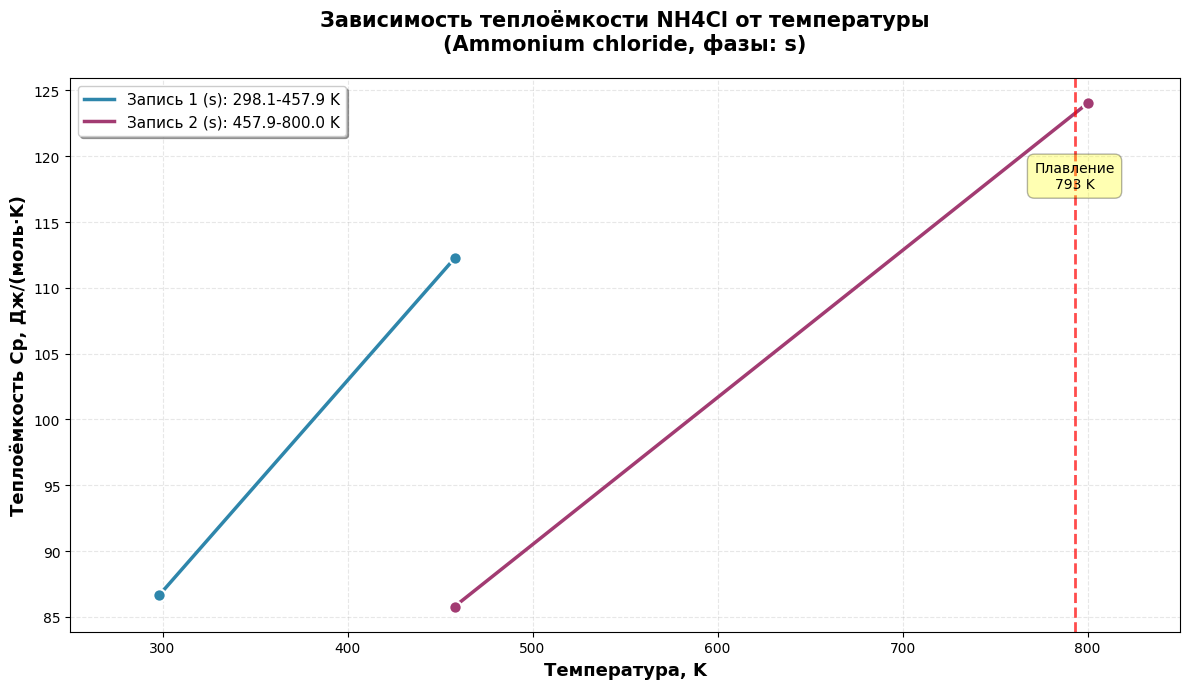

✓ График Cp(T) для NH4Cl построен



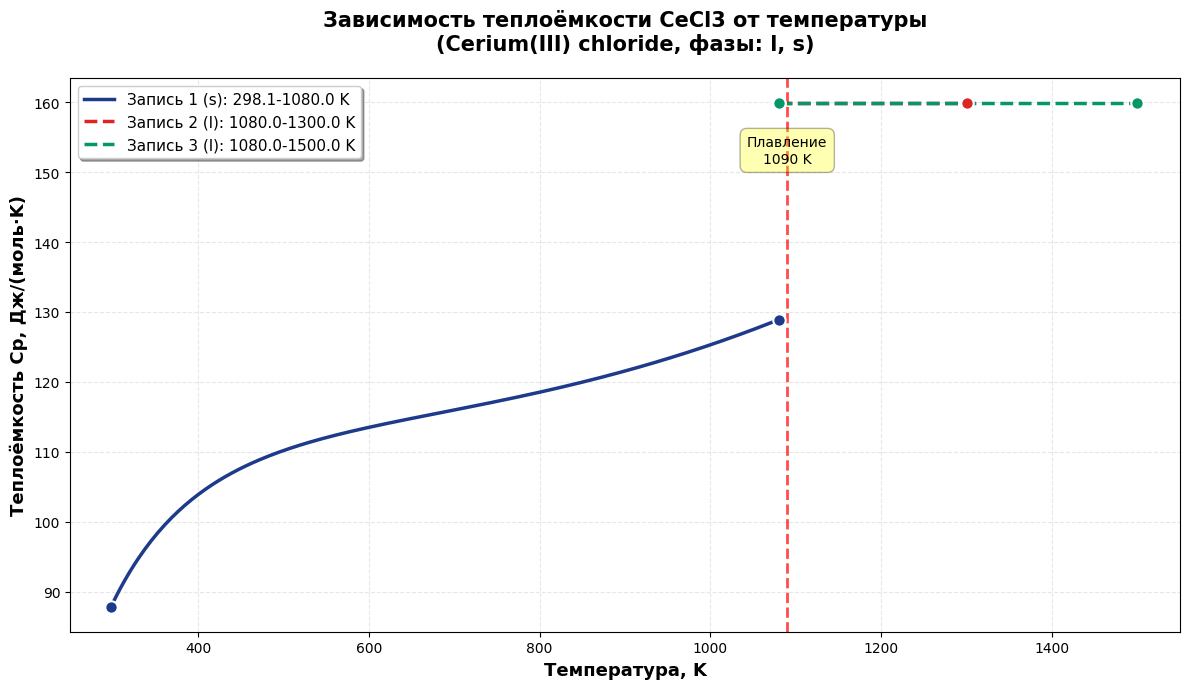

✓ График Cp(T) для CeCl3 построен



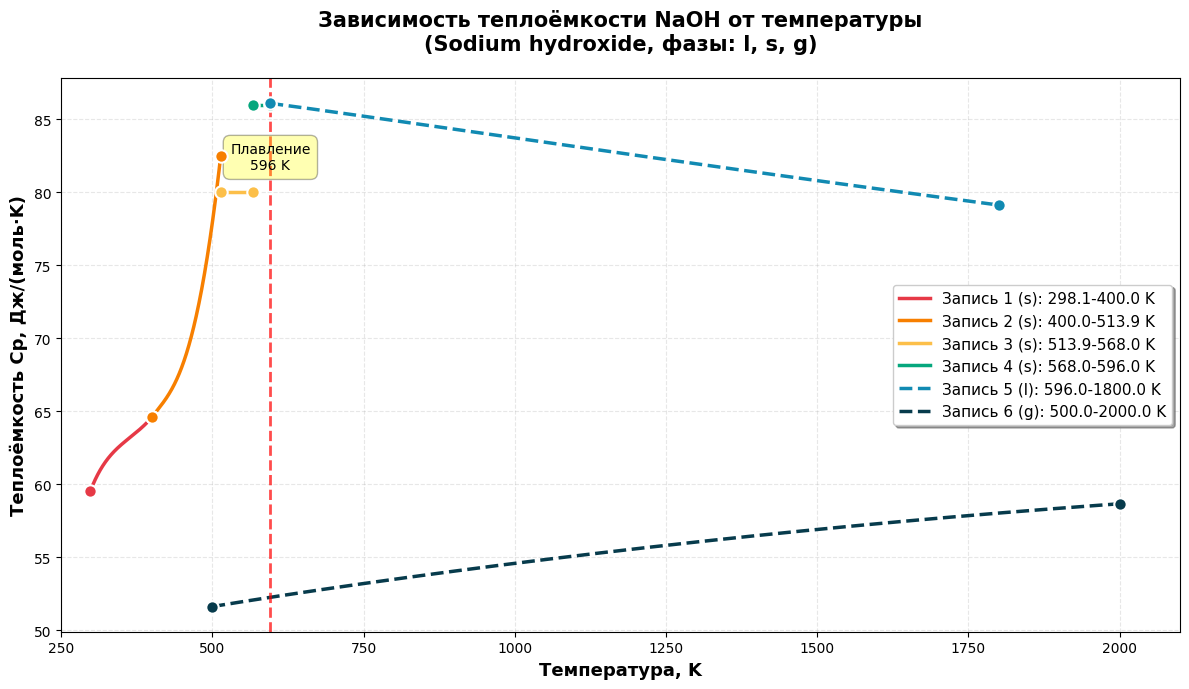

✓ График Cp(T) для NaOH построен



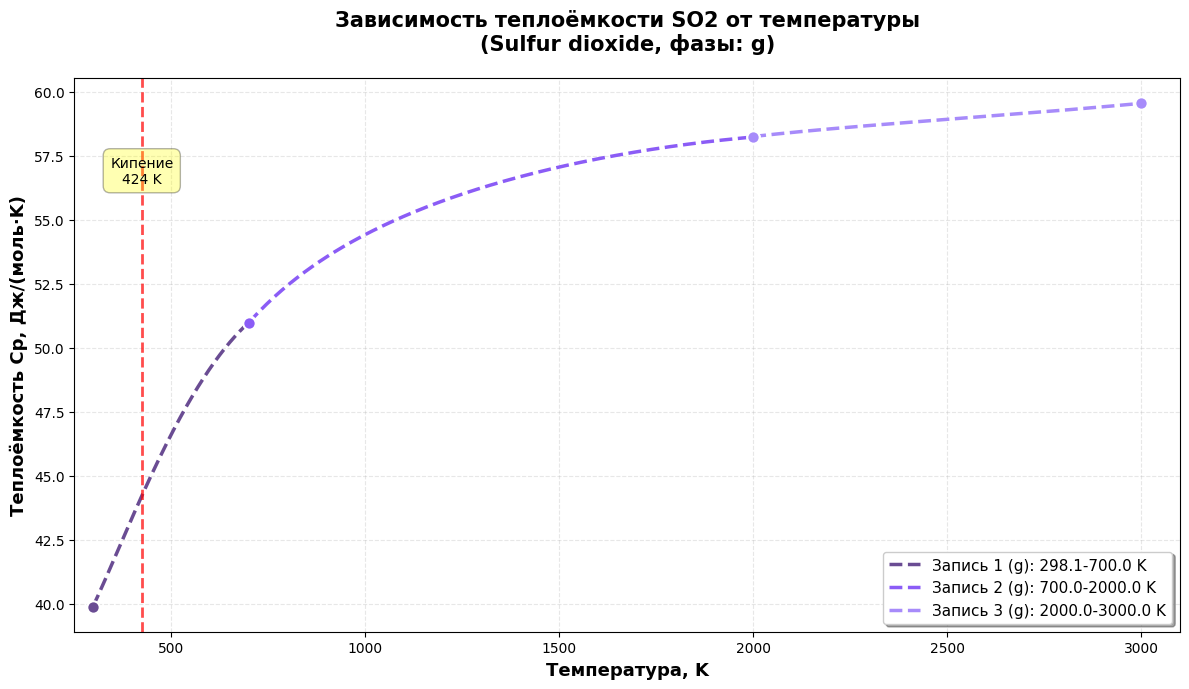

✓ График Cp(T) для SO2 построен



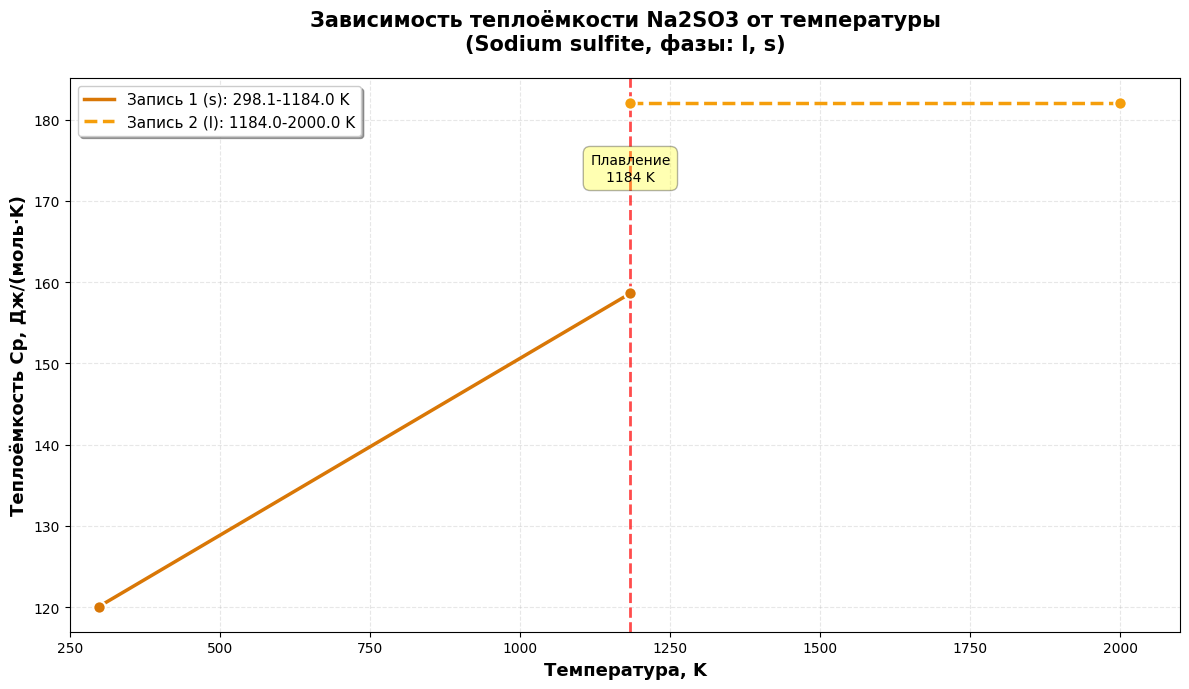

✓ График Cp(T) для Na2SO3 построен



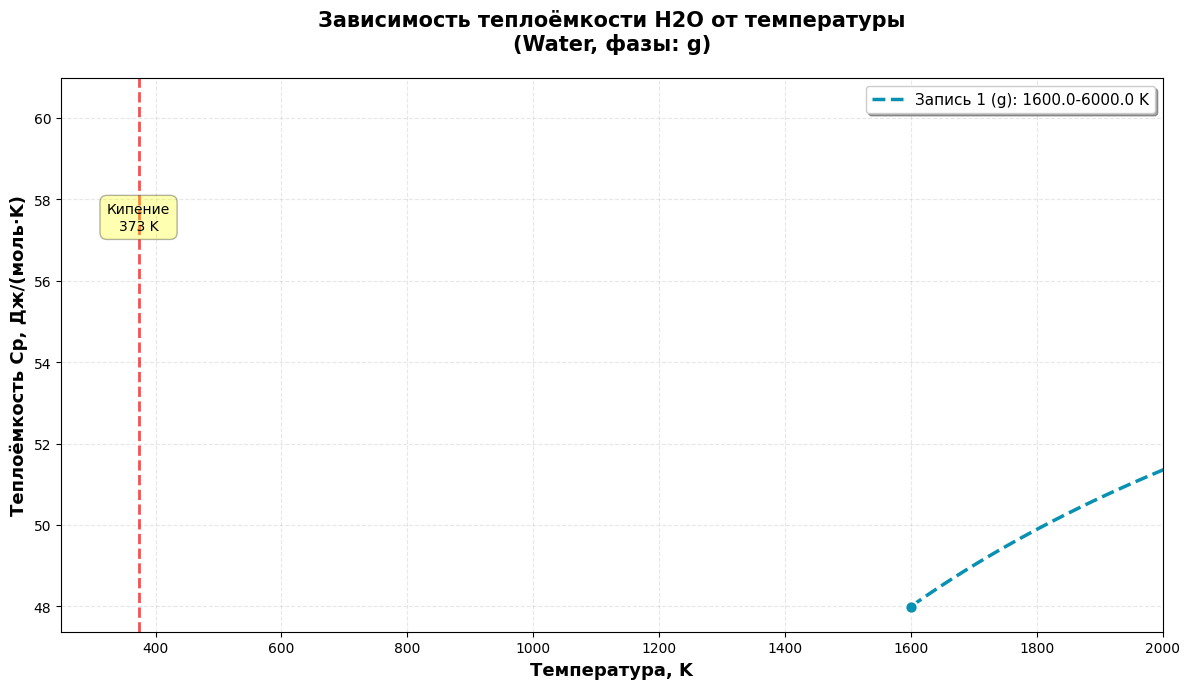

✓ График Cp(T) для H2O построен



In [172]:
# Построение графиков Cp(T) для всех веществ
for formula, data in compound_data.items():
    config = data['config']
    records = data['records']
    
    if not records:
        print(f"⚠ Нет данных для {formula}, пропускаем")
        continue
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Строим графики для каждой записи
    for idx, record in enumerate(records):
        # DatabaseRecord использует атрибуты, а не словарь
        T_min = record.tmin
        T_max = record.tmax
        phase = record.phase
        
        # Массив температур
        temperatures = np.linspace(T_min, T_max, 200)
        
        # Рассчитываем Cp для каждой температуры
        cp_values = [calculate_cp(record, T) for T in temperatures]
        
        # Строим график
        label = f"Запись {idx+1} ({phase}): {T_min:.1f}-{T_max:.1f} K"
        linestyle = '-' if phase == 's' else '--'
        color = config['colors'][idx % len(config['colors'])]
        
        ax.plot(temperatures, cp_values, 
                label=label, 
                linewidth=2.5,
                color=color,
                linestyle=linestyle)
        
        # Добавляем точки на границах диапазона
        ax.scatter([T_min, T_max], 
                  [calculate_cp(record, T_min), calculate_cp(record, T_max)],
                  color=color, 
                  s=80, 
                  zorder=5,
                  edgecolors='white',
                  linewidths=1.5)
    
    # Оформление графика
    ax.set_xlabel('Температура, K', fontsize=13, fontweight='bold')
    ax.set_ylabel('Теплоёмкость Cp, Дж/(моль·K)', fontsize=13, fontweight='bold')
    
    phase_text = ', '.join(set(rec.phase for rec in records))
    ax.set_title(f'Зависимость теплоёмкости {formula} от температуры\n({config["name"]}, фазы: {phase_text})', 
                 fontsize=15, fontweight='bold', pad=20)
    
    ax.legend(fontsize=11, frameon=True, shadow=True, fancybox=True)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    ax.set_xlim(config['temp_range'])
    
    # Добавляем информацию о фазовом переходе
    if 'phase_transition' in config:
        trans = config['phase_transition']
        ax.axvline(x=trans['temp'], color='red', linestyle='--', linewidth=2, alpha=0.7)
        ax.text(trans['temp'], ax.get_ylim()[1] * 0.95, f"{trans['name']}\n{trans['temp']} K", 
                ha='center', va='top', fontsize=10, 
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ График Cp(T) для {formula} построен\n")


C:\Users\davjd\AppData\Local\Temp\ipykernel_13288\992820018.py:88: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  delta_H = np.trapz(cp_values, temp_points)
C:\Users\davjd\AppData\Local\Temp\ipykernel_13288\992820018.py:92: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  delta_S = np.trapz(cp_over_T, temp_points)


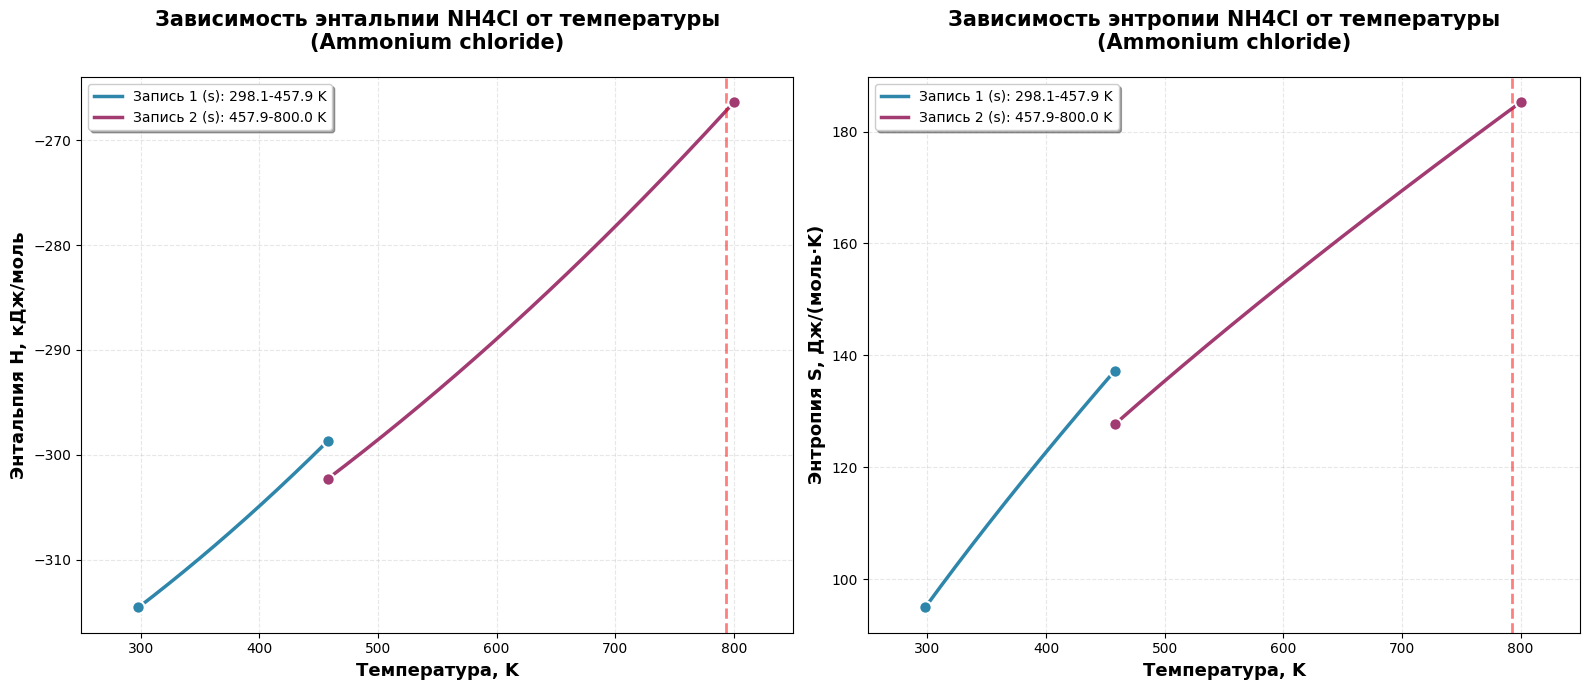

✓ Графики H(T) и S(T) для NH4Cl построены

   🔄 CeCl3: смена фазы s→l, новые референсные значения H₂₉₈=53.14, S₂₉₈=49.20


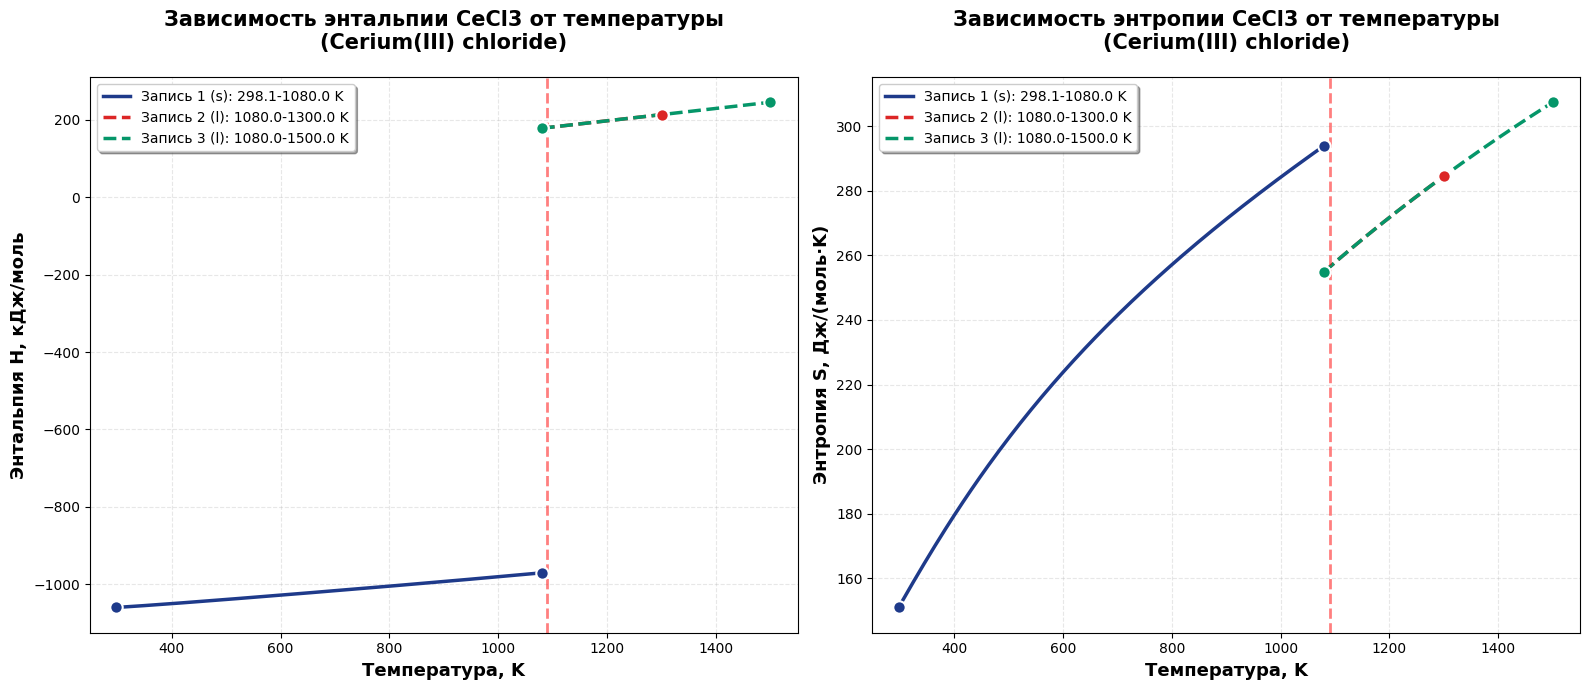

✓ Графики H(T) и S(T) для CeCl3 построены

   🔄 NaOH: смена фазы s→l, новые референсные значения H₂₉₈=6.36, S₂₉₈=10.72
   ⚠️  NaOH: смена фазы l→g, но H₂₉₈=0.00 и S₂₉₈=0.00 оба нулевые, сохраняем референсные значения предыдущей фазы


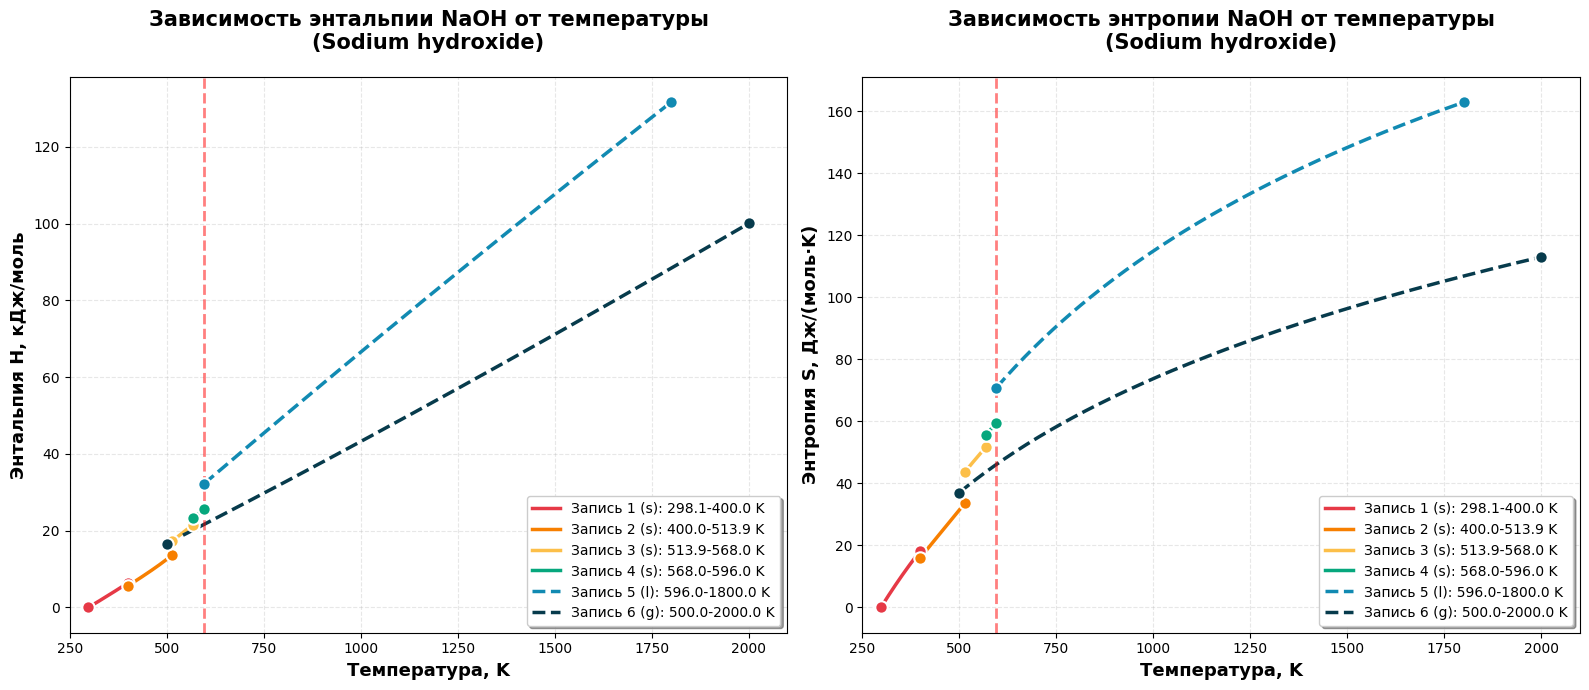

✓ Графики H(T) и S(T) для NaOH построены



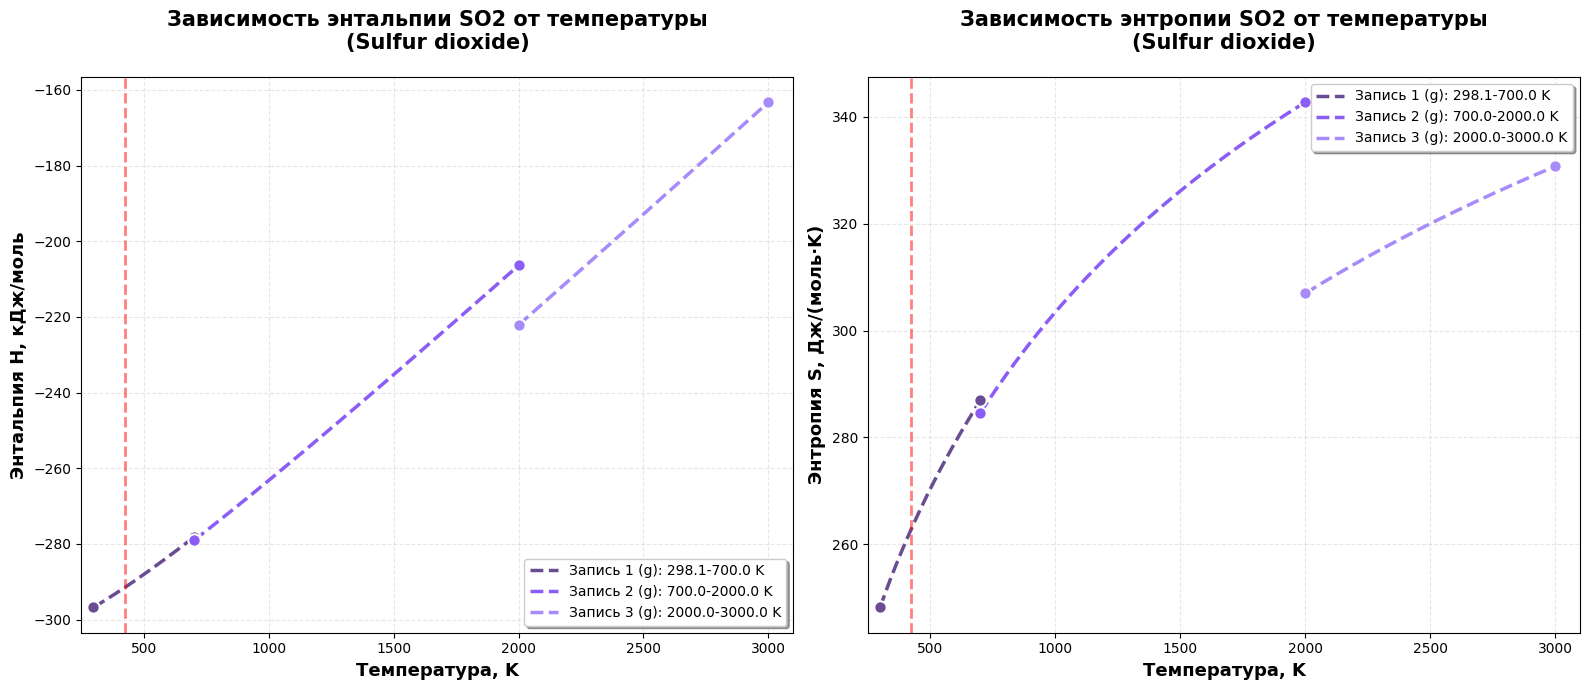

✓ Графики H(T) и S(T) для SO2 построены

   🔄 Na2SO3: смена фазы s→l, новые референсные значения H₂₉₈=25.86, S₂₉₈=21.84


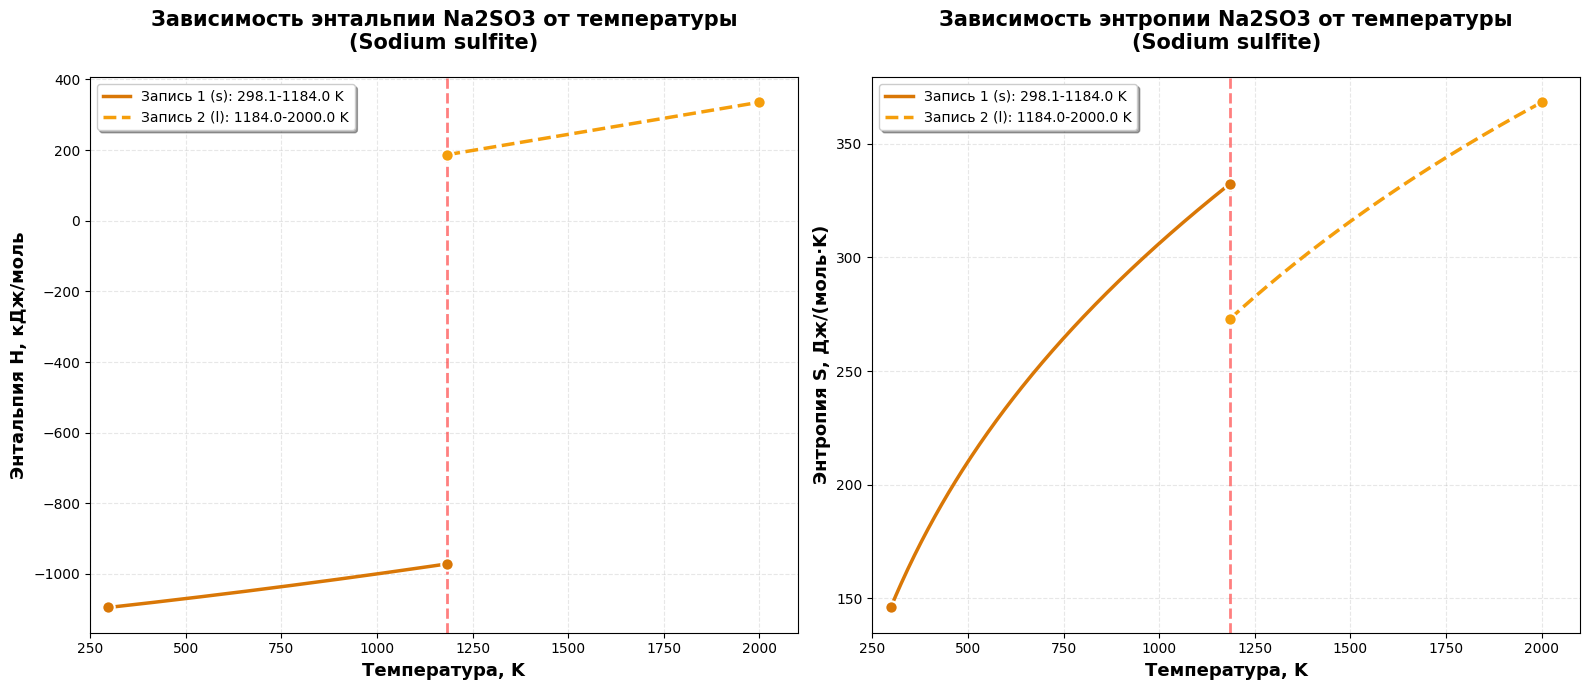

✓ Графики H(T) и S(T) для Na2SO3 построены



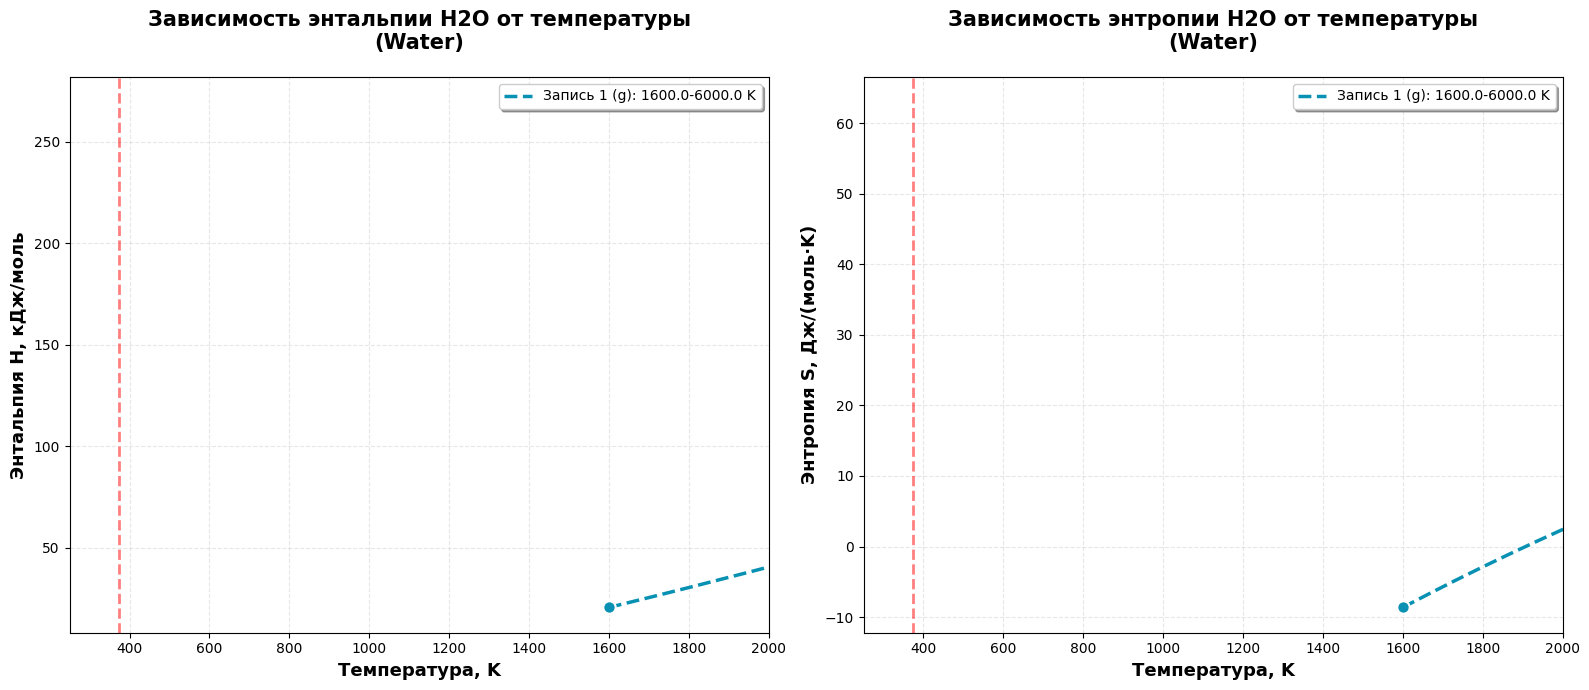

✓ Графики H(T) и S(T) для H2O построены



In [173]:
# Построение графиков H(T) и S(T) для всех веществ
for formula, data in compound_data.items():
    config = data['config']
    records = data['records']
    reference_record = data['reference_record']
    
    if not records or not reference_record:
        print(f"⚠ Нет данных для {formula}, пропускаем")
        continue
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Строим графики для каждой записи
    for idx, record in enumerate(records):
        # DatabaseRecord использует атрибуты, а не словарь
        T_min = record.tmin
        T_max = record.tmax
        phase = record.phase
        
        # Определяем референсную запись для текущей записи
        # Если это первая запись или фаза изменилась - используем H₂₉₈ и S₂₉₈ текущей записи
        if idx == 0:
            # Первая запись - используем общую референсную запись (с 298.15 K)
            current_reference = reference_record
        else:
            # Проверяем, изменилась ли фаза по сравнению с предыдущей записью
            previous_phase = records[idx - 1].phase
            if phase != previous_phase:
                # Фаза изменилась - проверяем, есть ли валидные данные в текущей записи
                # Если H₂₉₈ и S₂₉₈ оба равны нулю, не меняем референсную запись
                if abs(record.h298) < 1e-6 and abs(record.s298) < 1e-6:
                    # Нулевые значения - используем предыдущую референсную запись
                    current_reference = reference_record if idx == 1 else records[idx - 1]
                    # Для записей той же фазы находим первую запись этой фазы
                    for i in range(idx - 1, -1, -1):
                        if i == 0 or records[i].phase != records[i - 1].phase:
                            current_reference = reference_record if i == 0 else records[i]
                            break
                    print(f"   ⚠️  {formula}: смена фазы {previous_phase}→{phase}, "
                          f"но H₂₉₈={record.h298:.2f} и S₂₉₈={record.s298:.2f} оба нулевые, "
                          f"сохраняем референсные значения предыдущей фазы")
                else:
                    # Есть валидные данные - используем текущую запись
                    current_reference = record
                    print(f"   🔄 {formula}: смена фазы {previous_phase}→{phase}, "
                          f"новые референсные значения H₂₉₈={record.h298:.2f}, S₂₉₈={record.s298:.2f}")
            else:
                # Фаза не изменилась - используем ту же референсную запись
                current_reference = reference_record if idx == 1 else records[idx - 1]
                # Для записей той же фазы находим первую запись этой фазы
                for i in range(idx, -1, -1):
                    if i == 0 or records[i].phase != records[i - 1].phase:
                        current_reference = reference_record if i == 0 else records[i]
                        break
        
        # Массив температур
        temperatures = np.linspace(T_min, T_max, 200)
        
        # Рассчитываем H(T) и S(T) для каждой температуры
        H_values = []
        S_values = []
        
        for T in temperatures:
            H, S = calculate_H_S(record, current_reference, T)
            H_values.append(H)
            S_values.append(S)
        
        label = f"Запись {idx+1} ({phase}): {T_min:.1f}-{T_max:.1f} K"
        linestyle = '-' if phase == 's' else '--'
        color = config['colors'][idx % len(config['colors'])]
        
        # График энтальпии
        ax1.plot(temperatures, H_values, 
                label=label, 
                linewidth=2.5,
                color=color,
                linestyle=linestyle)
        ax1.scatter([T_min, T_max], 
                   [H_values[0], H_values[-1]],
                   color=color, 
                   s=80, 
                   zorder=5,
                   edgecolors='white',
                   linewidths=1.5)
        
        # График энтропии
        ax2.plot(temperatures, S_values, 
                label=label, 
                linewidth=2.5,
                color=color,
                linestyle=linestyle)
        ax2.scatter([T_min, T_max], 
                   [S_values[0], S_values[-1]],
                   color=color, 
                   s=80, 
                   zorder=5,
                   edgecolors='white',
                   linewidths=1.5)
    
    # Оформление графика энтальпии
    ax1.set_xlabel('Температура, K', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Энтальпия H, кДж/моль', fontsize=13, fontweight='bold')
    ax1.set_title(f'Зависимость энтальпии {formula} от температуры\n({config["name"]})', 
                 fontsize=15, fontweight='bold', pad=20)
    ax1.legend(fontsize=10, frameon=True, shadow=True, fancybox=True)
    ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    ax1.set_xlim(config['temp_range'])
    
    # Оформление графика энтропии
    ax2.set_xlabel('Температура, K', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Энтропия S, Дж/(моль·K)', fontsize=13, fontweight='bold')
    ax2.set_title(f'Зависимость энтропии {formula} от температуры\n({config["name"]})', 
                 fontsize=15, fontweight='bold', pad=20)
    ax2.legend(fontsize=10, frameon=True, shadow=True, fancybox=True)
    ax2.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    ax2.set_xlim(config['temp_range'])
    
    # Добавляем фазовый переход на обоих графиках
    if 'phase_transition' in config:
        trans = config['phase_transition']
        ax1.axvline(x=trans['temp'], color='red', linestyle='--', linewidth=2, alpha=0.5)
        ax2.axvline(x=trans['temp'], color='red', linestyle='--', linewidth=2, alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Графики H(T) и S(T) для {formula} построены\n")
